In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from functions import compute_r, rho_model, log_rho_model, compute_r_fast

import pandas as pd
import numpy as np
from itertools import zip_longest
import re
import os

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.special import gammaln
from scipy.optimize import differential_evolution

In [ ]:
filename = 'pDAT163010'
save_path = f'csv_output/{filename}_output/' 
params_file = '_params.csv'

event_number = 1
event_filename = save_path + f'event_{event_number}.csv'

In [ ]:
params_df = pd.read_csv(save_path + params_file)

In [ ]:
X0, Y0 = 0, 0
Ne, s = params_df['Ne'].iloc[event_number ], params_df['s'].iloc[event_number ]
theta, phi = params_df['theta'].iloc[event_number ], params_df['phi'].iloc[event_number ]

In [ ]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(3)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684
2,1,1.3,-37.609,-7.315,-6.684


In [ ]:
event_df = pd.read_csv(event_filename)
event_df.head(3)

,event_id,particle_name,pid,x,y,t,energy,theta_prim,phi_prim,energy_prim
0,1,gamma,1,667.646797,503.019609,83046.300,0.001015,30.0,157.84328,10000000.0
1,1,e-,2,666.912422,500.745625,83045.234,0.025016,30.0,157.84328,10000000.0
2,1,gamma,1,46.742075,1008.533984,83006.060,0.001490,30.0,157.84328,10000000.0


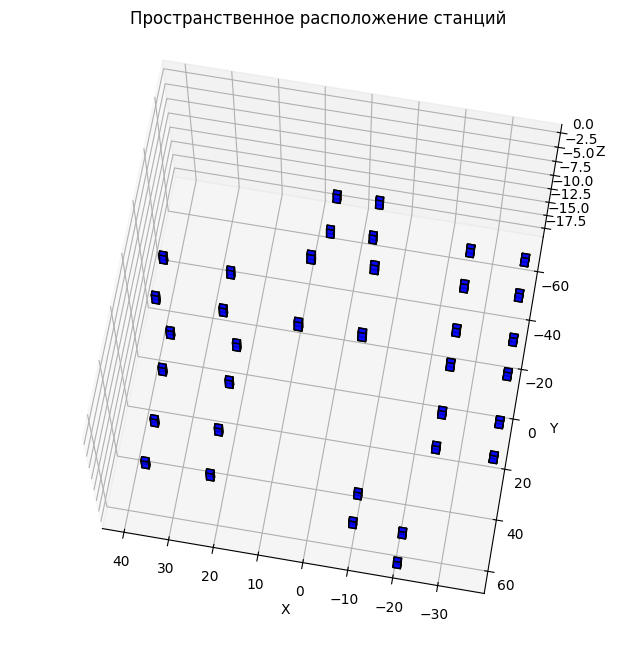

In [200]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

df = coordinates_df

cube_size = 1.6
def draw_cube(ax, x, y, z, size, color):
    r = [-size/2, size/2]
    vertices = [[x+r[i], y+r[j], z+r[k]] for i in range(2) for j in range(2) for k in range(2)]
    faces = [
        [vertices[0], vertices[1], vertices[3], vertices[2]],  # Bottom face
        [vertices[4], vertices[5], vertices[7], vertices[6]],  # Top face
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front face
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back face
        [vertices[0], vertices[2], vertices[6], vertices[4]],  # Left face
        [vertices[1], vertices[3], vertices[7], vertices[5]],  # Right face
    ]
    ax.add_collection3d(Poly3DCollection(faces, color=color, edgecolor="k", alpha=0.8))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for _, row in df.iterrows():
    color = "b"
    draw_cube(ax, row["X"], row["Y"], row["Z"], cube_size, color)

ax.set_xlim(df["X"].min() - 1, df["X"].max() + 1)
ax.set_ylim(df["Y"].min() - 1, df["Y"].max() + 1)
ax.set_zlim(df["Z"].min() - 1, df["Z"].max() + 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=70, azim=100)
ax.set_title("Пространственное расположение станций")

plt.show()

In [201]:
e_df = event_df[event_df['particle_name'].isin(['e-', 'e+'])].copy()
e_df.head()

,event_id,particle_name,pid,x,y,t,energy,theta_prim,phi_prim,energy_prim
1,1,e-,2,666.912422,500.745625,83045.234,0.025016,30.0,157.84328,10000000.0
14,1,e-,2,-729.121328,1625.722969,81114.350,0.027371,30.0,157.84328,10000000.0
16,1,e+,3,-805.963906,1645.153750,81016.800,0.007781,30.0,157.84328,10000000.0
18,1,e+,3,-866.878672,1692.802344,80970.920,0.007969,30.0,157.84328,10000000.0
42,1,e-,2,-954.409141,410.615430,80434.270,0.195669,30.0,157.84328,10000000.0


In [202]:
all_counts = [e_df[(e_df['x'].between(st.X - 0.4, st.X + 0.4)) & 
                  (e_df['y'].between(st.Y - 0.4, st.Y + 0.4))].shape[0]
             for st in coordinates_df.itertuples()]

# Затем группируем по 4
registration = [list(group) for group in zip_longest(*[iter(all_counts)]*4, fillvalue=None)]
registration = [[x for x in group if x is not None] for group in registration]

In [203]:
def compute_distance_from_axis(X0, Y0, theta, phi, X_det, Y_det):
    """
    Вычисляет расстояние от оси (X0,Y0) до станции (X_det,Y_det)
    при условии Z0 = Z_det (все Z координаты равны)
    
    Параметры:
        X0, Y0 - координаты оси
        theta, phi - углы направления оси (в градусах)
        X_det, Y_det - координаты станций
        
    Возвращает:
        Массив расстояний от оси до каждой станции
    """
    theta_rad = np.radians(theta)
    phi_rad = np.radians(phi)
    
    vx = np.cos(phi_rad) * np.sin(theta_rad)
    vy = np.sin(phi_rad) * np.sin(theta_rad)
    
    t = ((X_det - X0) * vx + (Y_det - Y0) * vy)
    
    P_ix = X0 + t * vx
    P_iy = Y0 + t * vy
    
    return np.sqrt((X_det - P_ix)**2 + (Y_det - P_iy)**2)

In [204]:
r_corsika = compute_distance_from_axis(X0, Y0, theta, phi, coordinates_df['X'], coordinates_df['Y'])

In [205]:
filtered_registration = []
filtered_r = []
filtered_coordinates = []  


cluster_indices = np.arange(len(coordinates_df)) // 4  

for cluster_id in np.unique(cluster_indices):
    mask = (cluster_indices == cluster_id)
    
    cluster_reg = registration[cluster_id]
    cluster_r = r_corsika[mask]
    cluster_coords = coordinates_df[mask]

    if sum(val > 0 for val in cluster_reg) >= 2:
        for reg_val, r_val, (_, coord_row) in zip(cluster_reg, cluster_r, cluster_coords.iterrows()):
            if reg_val > 0:
                filtered_registration.append(reg_val)
                filtered_r.append(r_val)
                filtered_coordinates.append(coord_row)

filtered_coordinates_df = pd.DataFrame(filtered_coordinates)
assert len(filtered_r) == len(filtered_coordinates_df) 

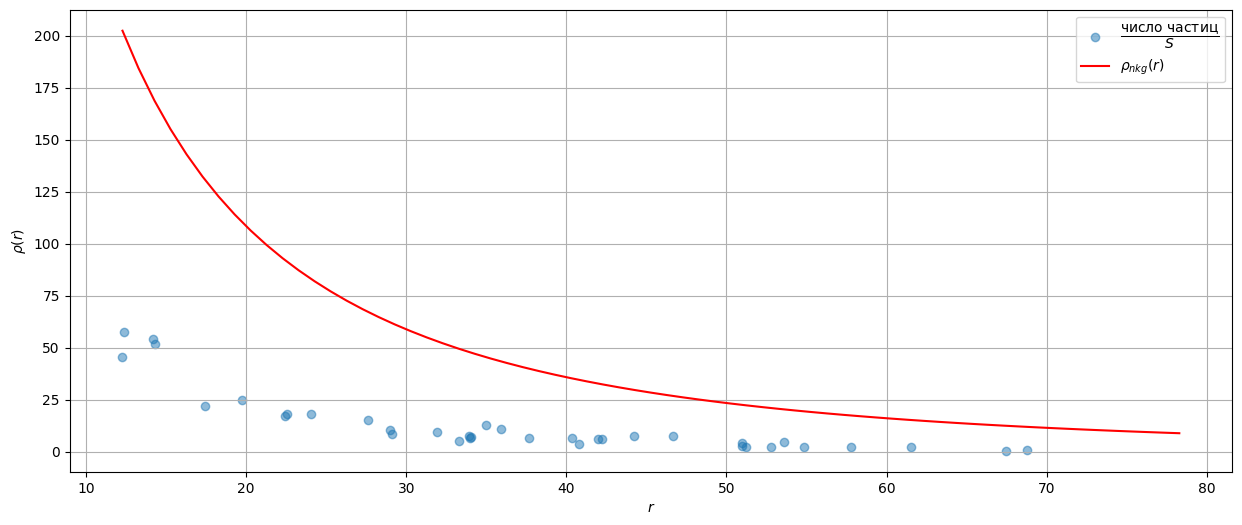

In [206]:
rho = np.array(filtered_registration) / (4 * 0.8 * 0.8)
r_enterval = np.arange(min(filtered_r), max(filtered_r) + 10, 1)
rho_calculate = rho_model(r_enterval, Ne, s)


plt.figure(figsize=(15, 6))
plt.scatter(filtered_r, rho , alpha=0.5, label=r'$\dfrac{\text{число частиц}}{S}$')
plt.plot(r_enterval, rho_calculate, c='r', label=r'$\rho_{nkg}(r)$')

plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
plt.legend()
plt.grid(True)
plt.show()

In [207]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    eps = 1e-10 
    X0, Y0, Ne, s = params
    X_det, Y_det = coordinates_df[['X', 'Y']].values.T
    Z_det = Z0
    r = compute_distance_from_axis(X0, Y0, theta, phi, X_det, Y_det)
    rho_calc = rho_model(r, Ne, s)
    return np.mean((np.log(rho_calc + eps) - np.log(rho + eps)) ** 2)

In [208]:
bounds = [
    (-50, 50),
    (-80, 80),
    (1, 1e8),  
    (0.2, 2)  
]

In [209]:
result = differential_evolution(
    loss_function,
    bounds,
    args=(filtered_coordinates_df, rho, theta, phi, -17)
    )

result = minimize(
    loss_function, 
    result.x, 
    args=(filtered_coordinates_df, rho, theta, phi, -17),
    method='Nelder-Mead', 
    bounds=bounds
)

X0_opt, Y0_opt, Ne_opt, s_opt = result.x

     X0    Y0        Ne     s
0  0.00  0.00  1.14e+06  1.26
1 -1.46  1.26  2.17e+05  0.80


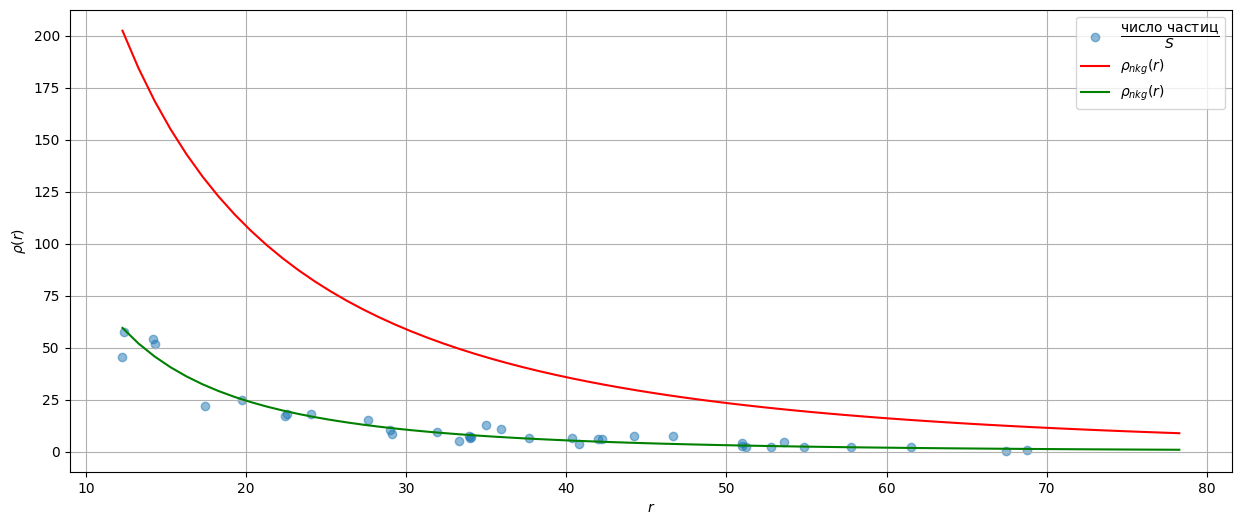

In [210]:
rho = np.array(filtered_registration) / (4 * 0.8 * 0.8)
r_enterval = np.arange(min(filtered_r), max(filtered_r) + 10, 1)
rho_calculate = rho_model(r_enterval, Ne, s)

R = compute_distance_from_axis(X0, Y0, theta, phi, filtered_coordinates_df['X'], filtered_coordinates_df['Y'])
rho_calculate_fit = rho_model(r_enterval, Ne_opt, s_opt)

df = pd.DataFrame({'X0': [X0, X0_opt], 'Y0': [Y0, Y0_opt]})
df = pd.DataFrame({
    'X0': np.round([X0, X0_opt], 2),
    'Y0': np.round([Y0, Y0_opt], 2),
    'Ne': [np.format_float_scientific(val, precision=2) for val in [Ne, Ne_opt]],
    's': np.round([s, s_opt], 2),
})
df.head(3)
print(df)

plt.figure(figsize=(15, 6))
plt.scatter(filtered_r, rho , alpha=0.5, label=r'$\dfrac{\text{число частиц}}{S}$')
plt.plot(r_enterval, rho_calculate, c='r', label=r'$\rho_{nkg}(r)$')
plt.plot(r_enterval, rho_calculate_fit, c='green', label=r'$\rho_{nkg}(r)$')


plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
plt.legend()
plt.grid(True)
plt.show()